In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os

2023-12-19 05:45:38.475506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Necessity

In [ ]:
test_results = glob.glob('../results/necessity_test/enformer/*pickle')

In [ ]:
track_index = [4824, 5110, 5111]
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]
tile_coords = pd.read_csv('../old_results//sufficiency_test/enformer/tile_coordinates.csv', index_col='Unnamed: 0').T
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]

In [ ]:
result_summary = {}
for c, cell_line in enumerate(cell_lines):
    normalized_effects = []
    cell_line_context = pd.read_csv(f'../results/context_dependence_test/enformer/{cell_line}_context.csv')
    print(c, cell_line)
    for _, row in cell_line_context.iterrows():
        res_path = row['path'].replace('context_dependence_test', 'necessity_test')
        res_raw = utils.read_pickle(res_path) 
        res = {k: r[:, :, c].mean(axis=1) for k, r in res_raw.items()}
        # res['mut'] = np.delete(res['mut'], 19)
        one_seq = pd.DataFrame((res['wt'] - res['mut']) / res['wt'])
        one_seq.columns = ['Normalized shuffle effect']
        one_seq['seq_id'] = res_path.split('/')[-1].split('.')[0]
        one_seq['tile_start'] = cre_tile_coords[0].values
        one_seq['tile_end'] = cre_tile_coords[1].values
        one_seq['context'] = row['context']
        normalized_effects.append(one_seq)
    result_summary[cell_line] = pd.concat(normalized_effects)

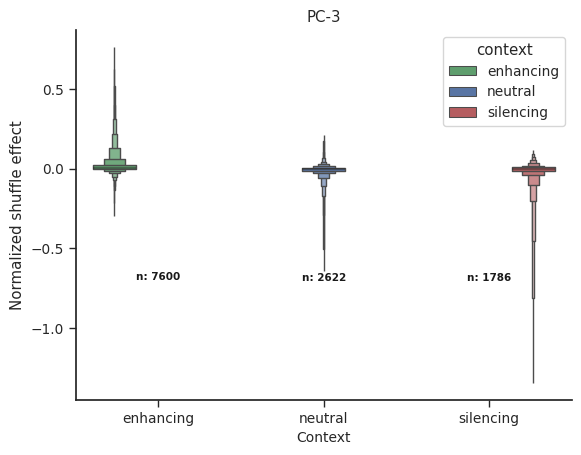

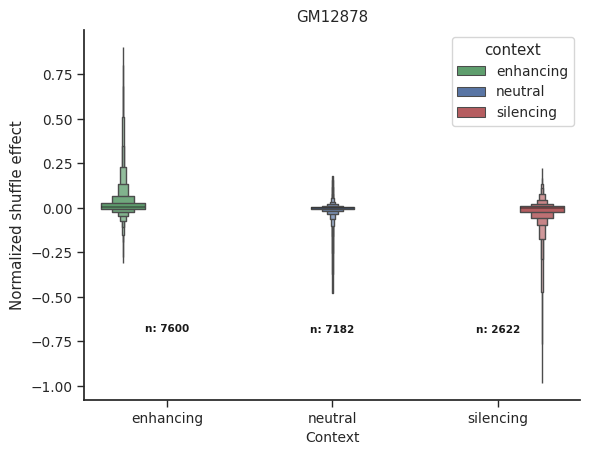

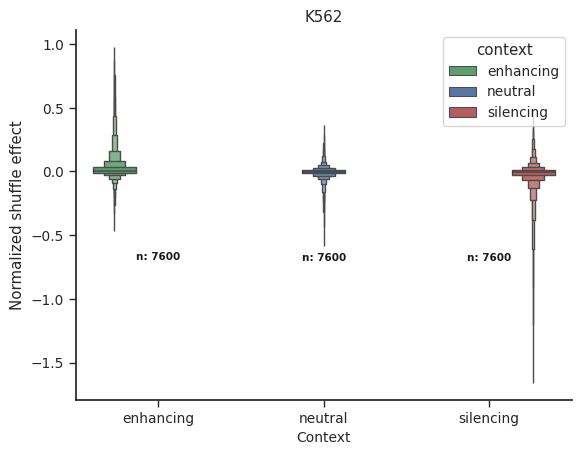

In [75]:
my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

for cell, df in result_summary.items():
    ax=sns.boxenplot(x='context', y='Normalized shuffle effect', data=df, 
                  showfliers=False,
                  hue='context',
                  palette = my_pal)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Context', fontsize=10)

    # add number of observations in each box
    medians = df.groupby(['context'])['Normalized shuffle effect'].median().values
    nobs = df['context'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],
                medians[tick] - .7,
                nobs[tick],
                horizontalalignment='center',
                size='x-small',
                color='k',
                weight='semibold')
    plt.title(cell)
    plt.show()
    

In [77]:
df

,Normalized shuffle effect,seq_id,tile_start,tile_end,context,cell_line
0,-0.006986,DAPK1_chr9_87497866_+,804,5804,enhancing,K562
1,0.011106,DAPK1_chr9_87497866_+,5804,10804,enhancing,K562
2,0.001816,DAPK1_chr9_87497866_+,10804,15804,enhancing,K562
3,-0.000423,DAPK1_chr9_87497866_+,15804,20804,enhancing,K562
4,-0.002954,DAPK1_chr9_87497866_+,20804,25804,enhancing,K562
...,...,...,...,...,...,...
33,-0.002138,ACSL6_chr5_131994579_-,170804,175804,silencing,K562
34,-0.014060,ACSL6_chr5_131994579_-,175804,180804,silencing,K562
35,0.001644,ACSL6_chr5_131994579_-,180804,185804,silencing,K562
36,-0.109519,ACSL6_chr5_131994579_-,185804,190804,silencing,K562


In [79]:
selected_cres = []
for cell, df in result_summary.items():
    df['cell_line'] = cell
    enh_df = df[(df['Normalized shuffle effect'] > 0.3) & (df['context']=='enhancing')]
    enh_df['tile class'] = 'Enhancer'
    selected_cres.append(enh_df)
    sil_df = df[(df['Normalized shuffle effect'] < -0.3) & (df['context']=='silencing')]
    sil_df['tile class'] = 'Silencer'
    selected_cres.append(sil_df)
selected_cres = pd.concat(selected_cres)

/tmp/ipykernel_184734/399000856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enh_df['tile class'] = 'Enhancer'
/tmp/ipykernel_184734/399000856.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sil_df['tile class'] = 'Silencer'
/tmp/ipykernel_184734/399000856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [81]:
selected_cres.groupby(['cell_line', 'tile class', 'context']).count()

Normalized shuffle effect  seq_id  tile_start   
cell_line tile class context                                                    
GM12878   Enhancer   enhancing                        159     159         159  \
          Silencer   silencing                         40      40          40   
K562      Enhancer   enhancing                        226     226         226   
          Silencer   silencing                        158     158         158   
PC-3      Enhancer   enhancing                        136     136         136   
          Silencer   silencing                         41      41          41   

                                tile_end  
cell_line tile class context              
GM12878   Enhancer   enhancing       159  
          Silencer   silencing        40  
K562      Enhancer   enhancing       226  
          Silencer   silencing       158  
PC-3      Enhancer   enhancing       136  
          Silencer   silencing        41

In [82]:
selected_cres.to_csv('../results/necessity_test/enformer_selected_cres.csv')

# Sufficiency

In [4]:
test_results = glob.glob('../results/sufficiency_test/enformer/*pickle')

In [5]:
track_index = [4824, 5110, 5111]
bin_index = [447, 448]
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]

In [6]:
tile_coords = pd.read_csv('../results/sufficiency_test/enformer/tile_coordinates.csv', index_col='Unnamed: 0').T
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]

In [9]:
result_summary = {}
for c, cell_line in enumerate(cell_lines):
    normalized_effects = []
    cell_line_context = pd.read_csv(f'../results/context_dependence_test_100/enformer/{cell_line}_context.csv')
    print(c, cell_line)
    for _, row in cell_line_context.iterrows():
        res_path = row['path'].replace('context_dependence_test_100', 'sufficiency_test')
        res = utils.read_pickle(res_path) 
        res['wt'] = res['wt'][bin_index, c].mean(axis=0)
        res['mut'] = res['mut'][:, bin_index, c].mean(axis=1)
        res['control'] = res['control'][:, bin_index, c].mean(axis=1)
        # one_seq = pd.DataFrame((res['mut'] - res['control']) / res['wt'])
        one_seq = pd.DataFrame((res['mut']-res['control']) / res['wt'])

        one_seq.columns = ['(MUT - CONTROL) / WT']
        one_seq['(MUT - CONTROL) / CONTROL'] = (res['mut']-res['control']) / res['control']
        one_seq['seq_id'] = res_path.split('/')[-1].split('.')[0]
        one_seq['control'] = res['control']
        one_seq['wt'] = res['wt']
        one_seq['mut'] = res['mut']
        one_seq['tile_start'] = cre_tile_coords[0].values
        one_seq['tile_end'] = cre_tile_coords[1].values
        one_seq['context'] = row['context']
        normalized_effects.append(one_seq)
    result_summary[cell_line] = pd.concat(normalized_effects)

0 PC-3
1 GM12878
2 K562


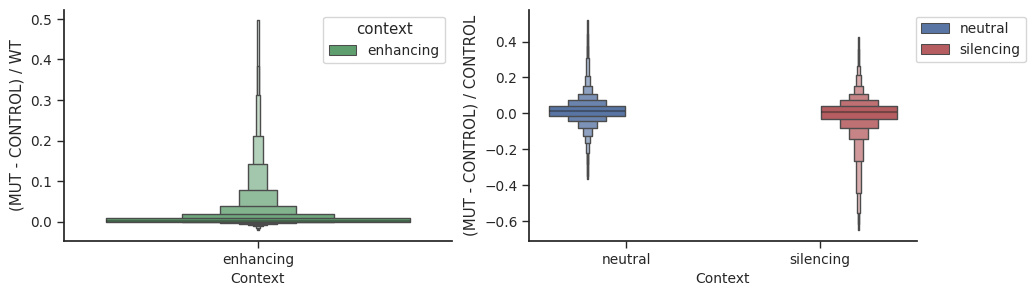

<Figure size 640x480 with 0 Axes>

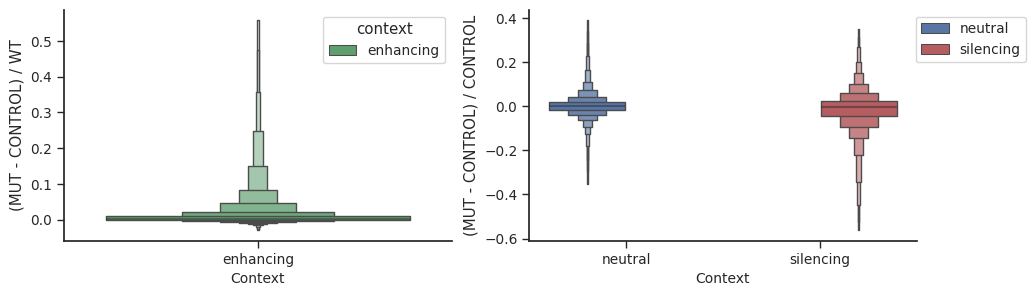

<Figure size 640x480 with 0 Axes>

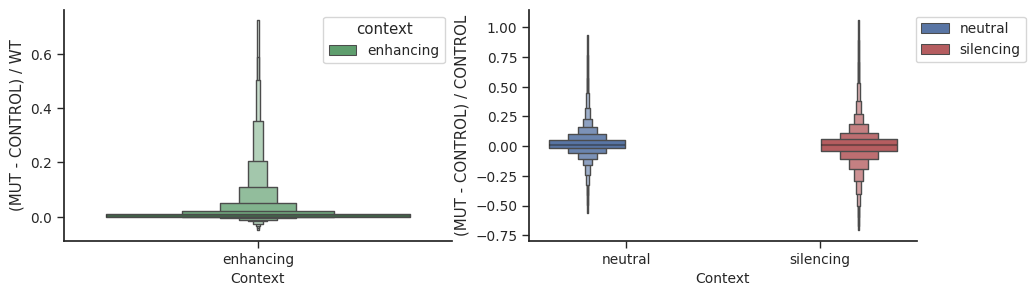

<Figure size 640x480 with 0 Axes>

In [10]:
my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True


for cell, df in result_summary.items():
    fig, axes = plt.subplots(1, 2, figsize=[11, 3])
    enh_cont = df[df['context'] == 'enhancing']
    others = df[df['context'] != 'enhancing']
    for p, (df_cont, y) in enumerate([[enh_cont, '(MUT - CONTROL) / WT'],
                                     [others, '(MUT - CONTROL) / CONTROL']]):
        ax = axes[p]
        sns.boxenplot(x='context', y=y, data=df_cont, 
                      showfliers=False,
                      hue='context',
                      ax=ax,
                      palette = my_pal)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Context', fontsize=10)
        
    plt.legend(bbox_to_anchor=[1.3,1])
    plt.show()
    plt.tight_layout()


        # add number of observations in each box
    # medians = df.groupby(['context'])[y].median().values
    # nobs = df['context'].value_counts().values
    # nobs = [str(x) for x in nobs.tolist()]
    # nobs = ["n: " + i for i in nobs]

    # # Add it to the plot
    # pos = range(len(nobs))
    # for tick,label in zip(pos,ax.get_xticklabels()):
    #     ax.text(pos[tick],
    #             medians[tick] - .7,
    #             nobs[tick],
    #             horizontalalignment='center',
    #             size='x-small',
    #             color='k',
    #             weight='semibold')
    # plt.title(cell)
    # # plt.ylim(0, 5)
    # plt.show()
    

In [11]:
print(result_summary['K562']['seq_id'].shape)
result_summary['K562']['seq_id'].unique().shape

(22800,)


(600,)

# threshold CREs for distance test

In [12]:
selected_cres = []
for cell, df in result_summary.items():
    df['cell_line'] = cell
    enh_cont_df = df[df['context']=='enhancing'] # only select enhancing CREs in enhancing contexts
    sil_cont_df = df[df['context']=='silencing'] # only select silencing CREs in silencing contexts
    enh_cont_df['Normalized CRE effect'] = enh_cont_df['(MUT - CONTROL) / WT'] # different norm for tiles from enh vs sil
    sil_cont_df['Normalized CRE effect'] = sil_cont_df['(MUT - CONTROL) / CONTROL']
    
    enh_cres = enh_cont_df[(enh_cont_df['Normalized CRE effect'] > 0.3)] 
    enh_cres['tile class'] = 'Enhancer'
    selected_cres.append(enh_cres)
    sil_cres = sil_cont_df[(sil_cont_df['Normalized CRE effect'] < -0.3)]
    sil_cres['tile class'] = 'Silencer'
    selected_cres.append(sil_cres)
selected_cres = pd.concat(selected_cres)

/tmp/ipykernel_3645104/188955257.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enh_cont_df['Normalized CRE effect'] = enh_cont_df['(MUT - CONTROL) / WT'] # different norm for tiles from enh vs sil
/tmp/ipykernel_3645104/188955257.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sil_cont_df['Normalized CRE effect'] = sil_cont_df['(MUT - CONTROL) / CONTROL']
/tmp/ipykernel_3645104/188955257.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [13]:
selected_cres.groupby(['cell_line', 'tile class', 'context']).count()

(MUT - CONTROL) / WT   
cell_line tile class context                           
GM12878   Enhancer   enhancing                    41  \
          Silencer   silencing                    57   
K562      Enhancer   enhancing                    74   
          Silencer   silencing                   222   
PC-3      Enhancer   enhancing                    35   
          Silencer   silencing                    97   

                                (MUT - CONTROL) / CONTROL  seq_id  control   
cell_line tile class context                                                 
GM12878   Enhancer   enhancing                         41      41       41  \
          Silencer   silencing                         57      57       57   
K562      Enhancer   enhancing                         74      74       74   
          Silencer   silencing                        222     222      222   
PC-3      Enhancer   enhancing                         35      35       35   
          Silencer   silencing                         97      97       97   

                                 wt  mut  tile_start  tile_end   
cell_line tile class context                                     
GM12878   Enhancer   enhancing   41   41          41        41  \
          Silencer   silencing   57   57          57        57   
K562      Enhancer   enhancing   74   74          74        74   
          Silencer   silencing  222  222         222       222   
PC-3      Enhancer   enhancing   35   35          35        35   
          Silencer   silencing   97   97          97        97   

                                Normalized CRE effect  
cell_line tile class context                           
GM12878   Enhancer   enhancing                     41  
          Silencer   silencing                     57  
K562      Enhancer   enhancing                     74  
          Silencer   silencing                    222  
PC-3      Enhancer   enhancing                     35  
          Silencer   silencing                     97

In [9]:
selected_cres.to_csv('../results/sufficiency_test/enformer_selected_cres.csv')